# Top 14 Rugby ?

par Benjamin Cerf, Tristan Delhaye & Mathieu Roig

<a id="intro"></a>
# Introduction

à rédiger, 
+ Démarche scientifique et reproductibilité du projet

<a id="sommaire"></a>
### Sommaire
- [Introduction](#intro)
  - [Sommaire](#sommaire)
  - [Installation](#installation)
- [Données](#données)
  - [Web-Scraping](#scraping)
  - [Nettoyage](#nettoyage)
  - [Regroupement](#regroupement)
  - [Mapping des noms de clubs](#mapping)
- [Statistiques Descriptives](#stats)
  - [Visualisation](#visual)
  - [Analyse](#analyse)
- [Modèle prédictif](#predict)
- [Conclusion](#conclu)

<a id="installation"></a>
### Installation

In [ ]:
#packages:
from io import StringIO
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import sys
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#lxml
subprocess.check_call([sys.executable, "-m", "pip", "install", "lxml"])

# ajouter pour partie predict

0

<a id="données"></a>
# Données

<a id="scraping"></a>
### Web-Scraping

Nous récupérons sur Wikipédia les données sur le championnat de France de rugby à XV de 2016 à aujourd'hui. Chaque saison a sa propre page wikipédia dédiée et la présentation des résultats peut légèrement différer en fonction de l'année: voir ici la saison [2016-2017](https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2016-2017) par rapport à la saison [2024-2025](https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2024-2025).

In [4]:
urls = [f"https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_{year}-{year+1}"
    for year in range(2016, 2025)]
print(urls)

['https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2016-2017', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2017-2018', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2018-2019', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2019-2020', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2020-2021', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2021-2022', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2022-2023', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2023-2024', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2024-2025']


Nous utilisons donc plusieurs versions d'une même fonction data dans scrapData.py qui récupère les tableaux de présentation générale, du classement, de son évolution, les résultats détaillés par match, et aussi la forme des équipes en fonction des jours de match.

In [5]:
sys.path.append(os.path.abspath('./scripts'))
from scrapData import data2325, data2223, data2122, data2021, data1920, data1619

tab1617 = data1619(urls[0])
tab1718 = data1619(urls[1])
tab1819 = data1619(urls[2])
tab1920 = data1920(urls[3])
tab2021 = data2021(urls[4])
tab2122 = data2122(urls[5])
tab2223 = data2223(urls[6])
tab2324 = data2325(urls[7])
tab2425 = data2325(urls[8])

<a id="nettoyage"></a>
### Nettoyage

La fonction nettoyage de cleanData.py uniformise les données du scraping. Les noms des équipes sont nettoyés, on se débarrasse des notes, et les classements sont tous mis sous forme numérique (ex: 1er -> 1, 2ème -> 2...). Les valeurs manquantes sont aussi remplacées par un tiret.

In [6]:
from cleanData import nettoyage

nettoyage(*tab1617)
nettoyage(*tab1718)
nettoyage(*tab1819)
nettoyage(*tab1920)
nettoyage(*tab2021)
nettoyage(*tab2122)
nettoyage(*tab2223)
nettoyage(*tab2324)
nettoyage(*tab2425)

<a id="regroupement"></a>
### Regroupement

Chaque tab est en réalité une liste de 5 dataframes. Nous allons donc pour chaque tableau fusionner les résultats des 9 dernières années, sauf celui des résultats globaux. 

In [43]:
# On va maintenant fusionner les tableaux, on change le nom pour faciliter la boucle :
tab1 = tab1617
tab2 = tab1718
tab3 = tab1819
tab4 = tab1920
tab5 = tab2021
tab6 = tab2122
tab7 = tab2223
tab8 = tab2324
tab9 = tab2425

# On crée une fonction qui permet d'ajouter une colonne année à chaque tableau pour bien pouvoir les séparer par année si besoin après
def ajout_an(df,i):
   df["année"] = 2016 + i
   return df

# On va faire maintenant une boucle pour concaténer les tableaux entre eux :
tableauglobal = [pd.DataFrame() for _ in range(5)]
# On remarquera que l'on ne prend pas le tableau résultat global car les équipes du championnat changent chaque année donc ce n'est pas possible de le concaténer

for j in range(1, 10):
    for i in range(5):
        if i == 2:
            pass  # on ne récupère pas le tableau résultat
        else:
         tableauglobal[i] = pd.concat([tableauglobal[i], ajout_an(eval(f"tab{j}")[i], j - 1)], ignore_index=True)

tab_presentation_global = tableauglobal[0]
tab_classement_global = tableauglobal[1]
tab_evolution_classement_global = tableauglobal[3]
tab_forme_global = tableauglobal[4]
tab_presentation_global['Budget en M€'] = pd.to_numeric(tab_presentation_global['Budget en M€'], errors='coerce')
tab_presentation_global['Classement précédent'] = pd.to_numeric(tab_presentation_global['Classement précédent'], errors='coerce')


<a id="mapping"></a>
### Mapping des noms de clubs

Enfin certaines équipes n'ont pas toujours leur nom écrit de la même façon.

In [40]:
presentation = tab_presentation_global
classement = tab_classement_global
evolution = tab_evolution_classement_global
forme = tab_forme_global

# Fusion des différentes données en un seul data frame
# On va fusionner les tableaux en se servant du club et de l'année comme clef
# On commence déjà par uniformiser le nom de la colonne 'Club':
evolution.rename(columns={'Equipes/Journées': 'Club'}, inplace=True)
forme.rename(columns={'Equipes/Journées': 'Club'}, inplace=True)

# En fait en faisant la fusion on se rend compte qu'un même club est appelé de manière différentes selon le tableau
# On va donc harmoniser ça
# On trouve les différences d'appelations grâce au code suivant : 
# Clés uniques dans chaque DataFrame
# keys_presentation = set(presentation[['Club', 'année']].itertuples(index=False, name=None))
# keys_classement = set(classement[['Club', 'année']].itertuples(index=False, name=None))
# keys_evolution = set(evolution[['Club', 'année']].itertuples(index=False, name=None))
# keys_forme = set(forme[['Club', 'année']].itertuples(index=False, name=None))
# Lignes présentes uniquement dans presentation
# diff_presentation = keys_presentation - keys_classement
# print("Lignes dans presentation mais pas dans classement :", diff_presentation)
#  # Lignes présentes uniquement dans classement
# diff_classement = keys_classement - keys_presentation
#  print("Lignes dans classement mais pas dans presentation :", diff_classement)
# Le premier tableau utilise la dénomination 'Stade français' tandis que le second 'Stade français Paris'
# On procède de même avec les différents tableaux pour observer toutes les appelations différentes (on le fait par rapport à classement)
# On répertorie alors ces appelations différentes pour pouvoir par la suite uniformiser tout les noms : 

mapping = {
    'Paris' : 'Stade français Paris',
    'Stade français': 'Stade français Paris',
    'Clermont': 'ASM Clermont',
    'La Rochelle': 'Stade rochelais',
    'Toulouse': 'Stade toulousain',
    'Bayonne': 'Aviron bayonnais',
    'Brive': 'CA Brive',
    'Montpellier': 'Montpellier HR',
    'Toulon': 'RC Toulon',
    'Castres': 'Castres olympique',
    'Pau': 'Section paloise',
    'Agen': 'SU Agen',
    'Grenoble': 'FC Grenoble',
    'Oyonnax': 'US Oyonnax',
    'Perpignan': 'USA Perpignan',
    'Bordeaux-Bègles': 'Union Bordeaux Bègles',
    'Bordeaux Bègles' : 'Union Bordeaux Bègles',
    'Lyon' : 'Lyon OU'
}

# On a plus qu'à uniformiser les noms dans tout les tableaux
presentation['Club'] = presentation['Club'].replace(mapping)
classement['Club'] = classement['Club'].replace(mapping)
forme['Club'] = forme['Club'].replace(mapping)
evolution['Club'] = evolution['Club'].replace(mapping)

#print(presentation.describe())
#print(classement.describe())
#print(forme.describe())
#print(evolution.describe())

On agrège ensuite les différents tableaux en un seul dataframe nommé données, pour les stocker dans le dossier data.

In [10]:
data = pd.merge(presentation, classement, on=['Club', 'année'], how='inner')
data = pd.merge(data, evolution, on=['Club', 'année'], how='inner')
data = pd.merge(data, forme, on=['Club', 'année'], how='inner')

data.to_csv('./data/données.csv', index=False)

# fixer les données nettoyées dans SSPcloud ?
#import s3fs
#MY_BUCKET =

<a id="stats"></a>
# Statistiques Descriptives

<a id="visual"></a>
### Visualisation

La fonction club de computeData permet d'obtenir les statistiques descriptives pour un club en particulier, pour chaque année qu'il passe dans le top 14: son budget en M€, son entraîneur, son rang, et le nombre de recontres jouées, dont les victoires et les défaites.

In [41]:
from computeData import club

#par exemple pour Toulouse:
toulouse=club("Stade toulousain", tab_presentation_global, tab_classement_global)
print(toulouse)

                       24/25     23/24     22/23     21/22     20/21  \
Budget en M€            49.0      46.3       NaN      37.3      36.6   
Entraîneur en chef  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola   
Rang                       2         1         1         4         1   
J                         12        26        26        26        26   
V                          8        16        17        15        17   
D                          3         9         8        11         8   
Diff                     159       173       208       206       210   

                       19/20     18/19     17/18     16/17  
Budget en M€            37.2      32.0     30.86      31.5  
Entraîneur en chef  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola  
Rang                       7         1         3        12  
J                         17        26        26        26  
V                          8        21        16        11  
D                          8         3         9        1

On peut visualiser l'évolution du budget des clubs au sein du championnat. 
et avec l'inflation ?
L'outlier en 2024 est le ? avec ??M€ de budget. Va-t-il gagner selon nos prévisions ?
Pourquoi 2022 manque ?

/tmp/ipykernel_58063/1235754585.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="année", y="Budget en M€", data=data_filtered, palette="YlOrBr")


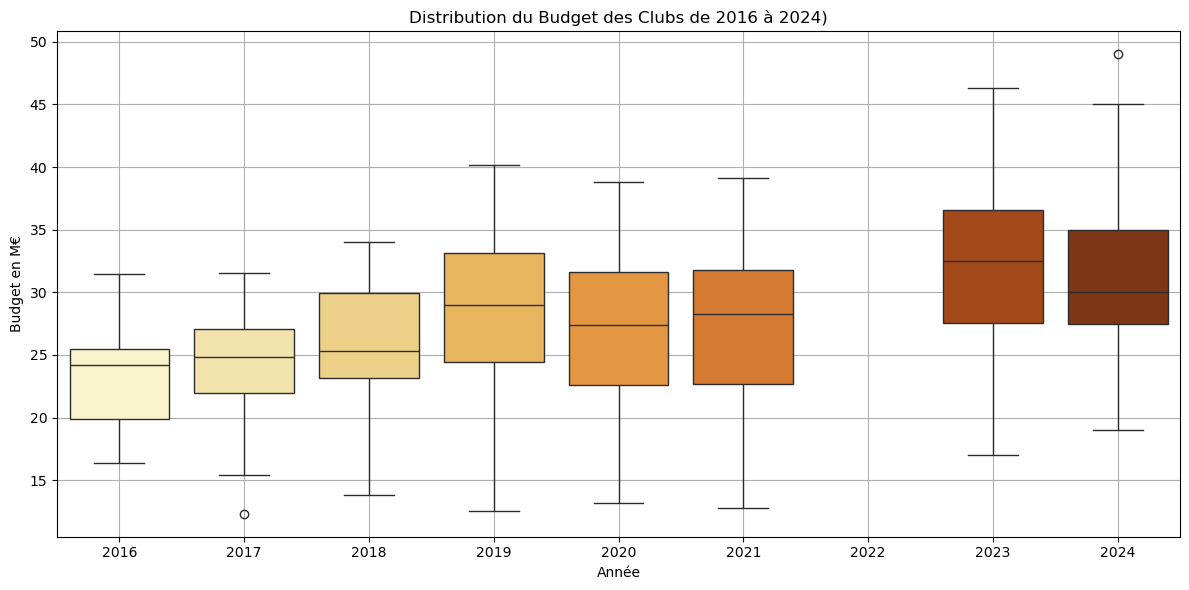

In [56]:
data_filtered = data[data["année"].isin(range(2016, 2025))]
plt.figure(figsize=(12, 6))
sns.boxplot(x="année", y="Budget en M€", data=data_filtered, palette="YlOrBr")

plt.title("Distribution du Budget des Clubs de 2016 à 2024)")
plt.xlabel("Année")
plt.ylabel("Budget en M€")

plt.grid(True)
plt.tight_layout()
plt.show()


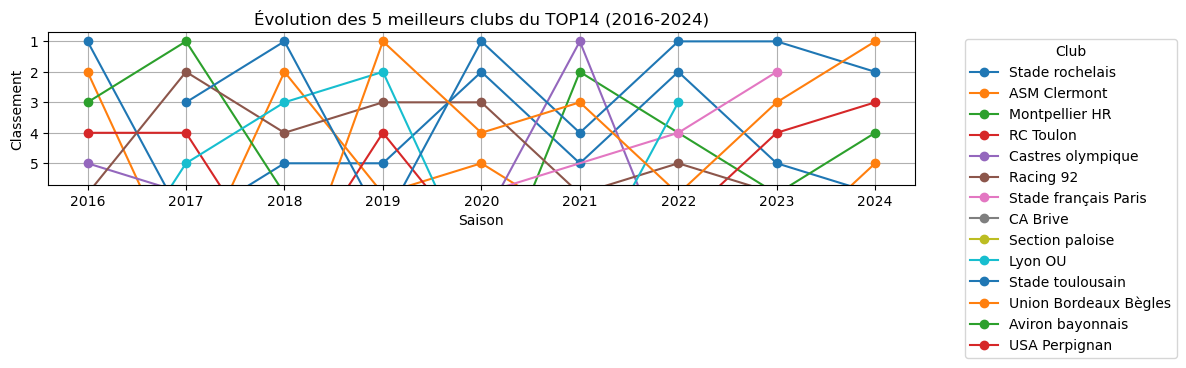

In [48]:
#filtrer pour le top10
top_10_per_year = (
    data.sort_values(by=["année", "Rang"])
    .groupby("année")
    .head(10)
    .sort_values(by=["année", "Rang"])
)

plt.figure(figsize=(12, 3))
for club in top_10_per_year["Club"].unique():
    club_data = top_10_per_year[top_10_per_year["Club"] == club]
    plt.plot(club_data["année"], club_data["Rang"], marker="o", label=club)

plt.gca().invert_yaxis()  # le 1 en haut !
plt.ylim(5.7, 0.7) # pour choisir le top?

plt.title("Évolution des 5 meilleurs clubs du TOP14 (2016-2024)")
plt.xlabel("Saison")
plt.ylabel("Classement")
plt.legend(title="Club", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

<a id="analyse"></a>
### Analyse

In [ ]:
from computeData import plot_club_evolution
plot_club_evolution("Stade toulousain", tab_classement, tab_resultats)

<a id="predict"></a>
# Modèle prédictif

<a id="conclu"></a>
# Conclusion

à rédiger, rester réaliste et dire ce qu'on aurait pu faire de mieux